In [1]:
import sys

from src.gauss_hist import get_gauss_stats

PWD = '../../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers

from src.network_utils import plot_difference_hist, gaussian_kernel, count_params
from src.cross_validator import AllChannelsCrossValidator
from src.dataset import X_TIME, TIME_STEP, load_dataset_train_test_all_channels
from src.models import optimal_model_builders_all_ch as optimal_model_builders

In [2]:
PROJECT_NAME = 'compare'

OVERWRITE = False

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_all/cross_val'

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 500
BATCH_SIZE = 8096

CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 3
LOSS_WEIGHT_REGULAR = 1000
LOSS_WEIGHT_HEATMAP = 1000
LOSS_WEIGHT_DIST = 1000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test_all_channels(PWD)

X_base_train[(2, 11)].shape, y_base_train[(2, 11)].shape

((20912, 24), (20912,))

In [4]:
y_base_train_heatmap = {key: np.array([gaussian_kernel(y) for y in val]) for key, val in y_base_train.items()}

y_base_train_heatmap[(2, 11)].shape

(20912, 24)

In [5]:
def compile_wrapper(builder, loss_weight):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=loss_weight)
        return model

    return compiled_builder

# Regular models

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.convnet, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.rnn, loss_weight=LOSS_WEIGHT_REGULAR),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = AllChannelsCrossValidator(regular_model_builders, list(X_base_train.values()),
                                            list(y_base_train.values()), CROSSVAL_DIR, PROJECT_NAME, n_epochs=N_EPOCHS,
                                            batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA, n_cv=CROSSVAL_N_CV,
                                            n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                            eval_metric=regular_metric, overwrite=OVERWRITE)

regular_model_scores = cross_validator()

Number of parameters: 3121
Got score: 79.3952 (79.2473, 79.4442, 79.4941)
Got score: 80.9845 (81.1947, 80.9982, 80.7606)
Got score: 79.5803 (79.6090, 79.5711, 79.5609)
Got score: 80.0212 (80.3050, 79.6886, 80.0701)
Got score: 79.3716 (79.4117, 79.2137, 79.4894)


Number of parameters: 44993
Got score: 79.7239 (79.7252, 79.0806, 80.3660)
Got score: 81.1030 (80.8066, 81.2452, 81.2570)
Got score: 79.8670 (79.6811, 79.6896, 80.2305)
Got score: 80.5157 (80.8042, 80.1965, 80.5464)
Got score: 79.6224 (79.5440, 79.6041, 79.7190)


Number of parameters: 50081
Got score: 79.8689 (79.7247, 79.8609, 80.0212)
Got score: 80.9425 (80.8563, 80.8913, 81.0799)
Got score: 79.7699 (79.9426, 79.7163, 79.6508)
Got score: 79.9710 (79.9605, 79.9113, 80.0411)
Got score: 79.4390 (79.8798, 79.4172, 79.0200)


# Heatmap-based models

Number of parameters: 2962785
Got score: 78.9276 (79.2129, 78.9389, 78.6310)
Got score: 78.1322 (78.2427, 78.0941, 78.0598)
Got score: 78.4924 (78.4993, 78.3551, 78.6227)


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


Got score: 78.2918 (78.3901, 78.1725, 78.3129)
Got score: 79.0103 (78.8711, 78.7078, 79.4519)


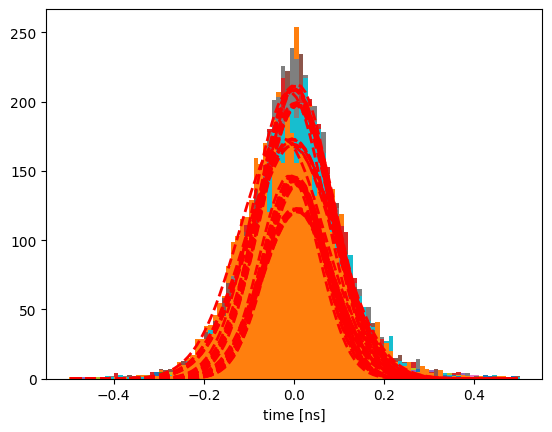

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet, loss_weight=LOSS_WEIGHT_HEATMAP)]
heatmap_model_names = ['unet']

cross_validator = AllChannelsCrossValidator(heatmap_model_builders, list(X_base_train.values()),
                                            list(y_base_train_heatmap.values()), CROSSVAL_DIR, PROJECT_NAME,
                                            n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                            n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC,
                                            model_names=heatmap_model_names, eval_metric=heatmap_metric,
                                            overwrite=OVERWRITE)

heatmap_model_scores = cross_validator()

# Comparison

In [8]:
all_model_builders = regular_model_builders + heatmap_model_builders
all_model_names = regular_model_names + heatmap_model_names
all_model_scores = regular_model_scores | heatmap_model_scores

In [9]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,79.87,0.60,3121
convnet,80.17,0.56,44993
rnn,80.00,0.50,50081
unet,78.57,0.35,2962785
